# Finding the point $(x_0,t_0)$ when the three solitons interact

### The question is, what is (x0,t0) when the solitons interact?, when we work on solutions with more than two solitons. Does this point even exist? Because one might wonder if it is possible for three solitons to collide simultaneously. The key idea is to study the maximum amplitude of the solution at each time. During the evolution, the solitons interact, and at the moment of strongest collision this maximum amplitude reaches its smallest possible value. By computing the infimum of these supremum values, we obtain both the time of collision and the position where the solitons overlap most strongly.
### The following code implements this idea. It constructs the three–soliton solution from the given parameters and then determines the time and location of the collision by finding the infimum of the supremums of the solutions.
### I tried to minize the parameters $\gamma_3, \kappa_3, \gamma_2, and \kappa_2$ in this program.


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import scipy.signal

import time

Below code generates the graphs of $u$ given the values of $u$ at each point $x$ using arrays

In [2]:
def make_plot(xarr, uarr, t, show=1, linewidth=1):
    plt.plot(xarr, uarr, linewidth=linewidth)    
    plt.ylim((-1, 3))
    umax = np.max(uarr)
    xmax = xarr[np.argmax(uarr)]
    
    peaks = scipy.signal.find_peaks(uarr, threshold=1e-6)
    negpeaks = scipy.signal.find_peaks(-uarr, threshold=1e-6)
    
    Npeaks = peaks[0].size
    Nnegpeaks = negpeaks[0].size
        
    plt.text(xarr[0], 2.4, "t={:.3}".format(t))
    plt.text(xarr[0], 2.6, "max={:.6}, xmax={:.6}".format(umax, xmax))
    plt.text(xarr[0], 2.8, "Num_peaks={}, Num_neg_peaks={}".format(Npeaks, Nnegpeaks))

    for i in range(Npeaks):
        index = peaks[0][i]
        plt.text(6, 2.4 + 0.2 * (Npeaks - i - 1), "Peak {}: x={:.3}, u={:.3}".format(i + 1, xarr[index], uarr[index]))

    for i in range(Nnegpeaks):
        index = negpeaks[0][i]
        plt.text(1, 1.6 + 0.2 * (Npeaks - i - 1), "Neg peak {}: x={:.3}, u={:.3}".format(i+1, xarr[index], uarr[index]))
    if (1 == show):
        plt.show()

Below code finds the pair of points where the given two solitons collide

In [3]:
def find_x0_t0(soliton1, soliton2):
    kappa1, gamma1square = soliton1
    kappa2, gamma2square = soliton2
    
    Mat = np.zeros((2, 3))
    Mat[0][0] = 1 
    Mat[0][1] = -4*kappa1**2
    Mat[0][2] = 1/(2*kappa1) * np.log(gamma1square / (2*kappa1)) - 1/(2*kappa1)*np.log((kappa1+kappa2)/(kappa1-kappa2))
    
    Mat[1][0] = 1 
    Mat[1][1] = -4*kappa2**2
    Mat[1][2] = 1/(2*kappa2) * np.log(gamma2square / (2*kappa2)) - 1/(2*kappa2)*np.log((kappa1+kappa2)/(kappa1-kappa2))
    
    x0, t0 = np.linalg.solve(Mat[:, :2], Mat[:, 2])
    
    return (x0, t0)

It constructs the three–soliton solution from the given parameters and then determines the time and location of the collision of three solitons by finding the infimum of the supremums of the solutions.

In [4]:
def find_inf_sup_three_solitons(sol1, sol2, sol3, plot=0):
    start = time.time()

    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    kappa3, gamma3square = sol3
    
    x12, t12 = find_x0_t0(sol1, sol2)
    x13, t13 = find_x0_t0(sol1, sol3)
    x23, t23 = find_x0_t0(sol2, sol3)
    
    pairwise_times = np.array([t12, t13, t23])
    pairwise_pos = np.array([x12, x13, x23])
    #print("pairwise_times: {}".format(pairwise_times))
    #print("pairwise_pos: {}".format(pairwise_times))
    
    tleft = np.min(pairwise_times)
    tright = np.max(pairwise_times)
    Nt = 100
    tarr = np.linspace(tleft - (tright - tleft)/2, tright + (tright - tleft)/2, Nt)
    
    #xleft = np.min(pairwise_pos)
    #xright = np.max(pairwise_pos)
    Nx = 1000
    #xarr = np.linspace(xleft - (xright - xleft)/2, xright + (xright - xleft)/2, Nx)
    xarr = np.linspace(-30, 30, Nx)
    
    
    Mat = np.zeros((tarr.shape[0], xarr.shape[0], 3, 4), dtype=float)

    theta1 = -2 * kappa1 * xarr.reshape(1, -1) + 8 * kappa1**3 * tarr.reshape(-1, 1)
    theta2 = -2 * kappa2 * xarr.reshape(1, -1) + 8 * kappa2**3 * tarr.reshape(-1, 1)
    theta3 = -2 * kappa3 * xarr.reshape(1, -1) + 8 * kappa3**3 * tarr.reshape(-1, 1)

    exp1 = np.where(theta1 <= 0, np.exp(theta1), np.exp(-theta1))
    exp2 = np.where(theta2 <= 0, np.exp(theta2), np.exp(-theta2))
    exp3 = np.where(theta3 <= 0, np.exp(theta3), np.exp(-theta3))

    Mat[:, :, 0, 0] = np.where(theta1 <= 0, 1 + exp1 * gamma1square / (2*kappa1), exp1 + gamma1square / (2 * kappa1))
    Mat[:, :, 0, 1] = np.where(theta1 <= 0, exp1 * gamma1square / (kappa1 + kappa2), gamma1square / (kappa1 + kappa2))
    Mat[:, :, 0, 2] = np.where(theta1 <= 0, gamma1square * exp1 / (kappa1 + kappa3), gamma1square / (kappa1 + kappa3))
    Mat[:, :, 0, 3] = np.where(theta1 <= 0, gamma1square * exp1, gamma1square)

    Mat[:, :, 1, 0] = np.where(theta2 <= 0, exp2 * gamma2square / (kappa1 + kappa2), gamma2square / (kappa1 + kappa2))
    Mat[:, :, 1, 1] = np.where(theta2 <= 0, 1 + exp2 * gamma2square / (2 * kappa2), exp2 + gamma2square / (2 * kappa2))
    Mat[:, :, 1, 2] = np.where(theta2 <= 0, gamma2square * exp2 / (kappa2 + kappa3), gamma2square / (kappa2 + kappa3))
    Mat[:, :, 1, 3] = np.where(theta2 <= 0, gamma2square * exp2, gamma2square)

    Mat[:, :, 2, 0] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa1 + kappa3), gamma3square / (kappa1 + kappa3))
    Mat[:, :, 2, 1] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa2 + kappa3), gamma3square / (kappa2 + kappa3))
    Mat[:, :, 2, 2] = np.where(theta3 <= 0, 1 + gamma3square * exp3 / (2 * kappa3), exp3 + gamma3square / (2 * kappa3))
    Mat[:, :, 2, 3] = np.where(theta3 <= 0, gamma3square * exp3, gamma3square)

    alphas = np.linalg.solve(Mat[:, :, :, :3], Mat[:, :, :, 3].reshape(Mat.shape[:-1] + (1,)))
    u = 4 * (alphas[:, :, 0] * kappa1 + alphas[:, :, 1] * kappa2 + alphas[:, :, 2] * kappa3)\
        - 2 * (alphas[:, :, 0] + alphas[:, :, 1] + alphas[:, :, 2])**2

    u = u.squeeze()

    uinfsup = np.min(np.max(u, axis=1))
    
    time_index = np.argmin(np.max(u, axis=1))
    
    if (1 == plot):
        plt.plot(xarr, u[time_index, :])
        for (t, uarr) in zip(tarr, u):
            plt.plot(xarr, uarr)
        make_plot(xarr, u[time_index, :], tarr[time_index])
    
    end = time.time()
    #print(end - start)
    return (xarr, u, uinfsup, time_index, tarr[time_index])

And below code minimizes the paramater $\gamma_3$ in order for the solitons to have smallest possible value when they collide. 

In [5]:
def find_gamma3(sol1, sol2, kappa3):
    '''determines gamma3, given two solitons and the kappa3 of the third soliton'''
    
    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    
    gamma3squarearr = np.linspace(0.1, 100, 100)
    #gamma3squarearr = np.exp(lngamma3squarearr)
    #print(gamma3squarearr)
    
    uinfsuparr = []
    wholeu_arr = []
    time_index_arr = []
    time_arr = []
    
    counter = 0
    for gamma3square in gamma3squarearr:
        #print("counter: {}\ngamma3square:{}".format(counter, gamma3square))
        counter += 1
        xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, (kappa3, gamma3square), 0)
        wholeu_arr.append(u)
        uinfsuparr.append(uinfsup)
        time_index_arr.append(time_index)
        time_arr.append(time)
        make_plot(xarr, u[time_index, :], time, show=1)
    
    index = np.argmin(uinfsuparr)
    gamma3squarearr[index]
    
    plt.plot(xarr, wholeu_arr[index][time_index_arr[index], :], )
    make_plot(xarr, wholeu_arr[index][time_index_arr[index], :], time_arr[index])
    
    plt.show()

    plt.plot(gamma3squarearr, uinfsuparr)
    
    return (np.min(np.array(uinfsuparr)), gamma3squarearr[index])

In [6]:
1/(2*kappa1) * np.log(gamma1square/(2*kappa1)), \
1/(2*kappa2) * np.log(gamma2square/(2*kappa2)), \
1/(2*kappa3) * np.log(100/(2*kappa3))

NameError: name 'kappa1' is not defined

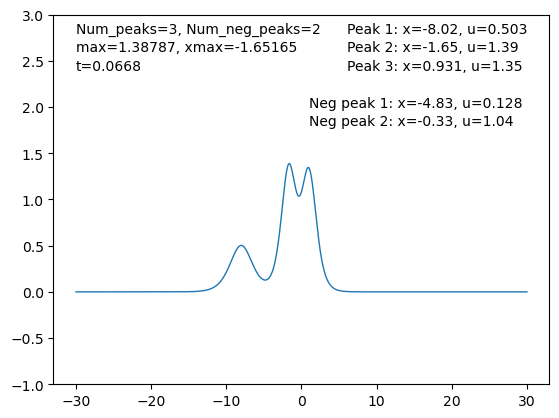

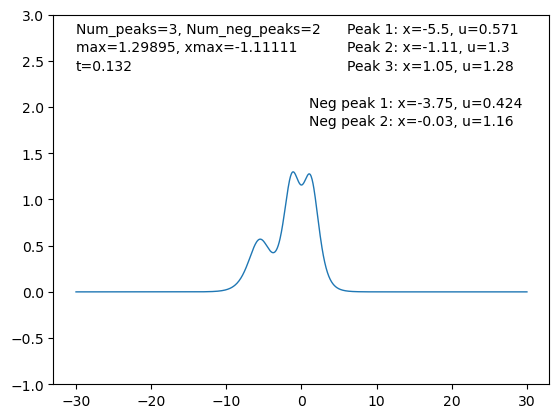

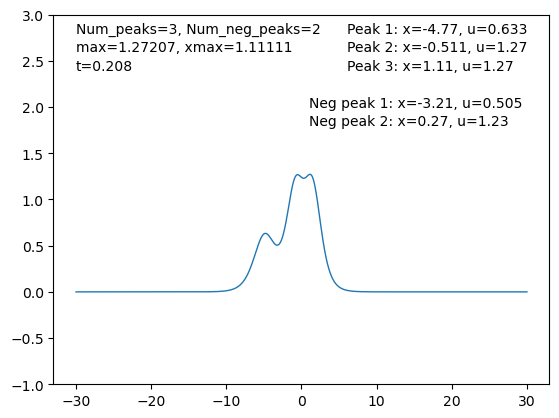

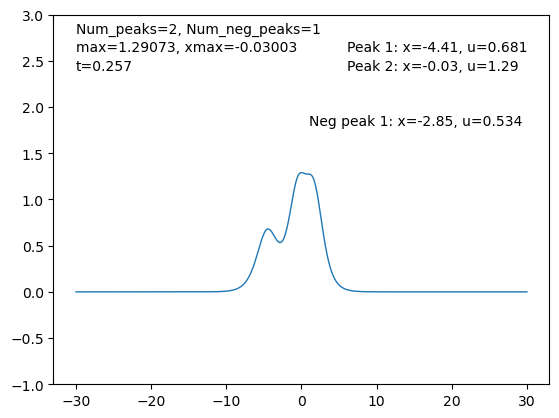

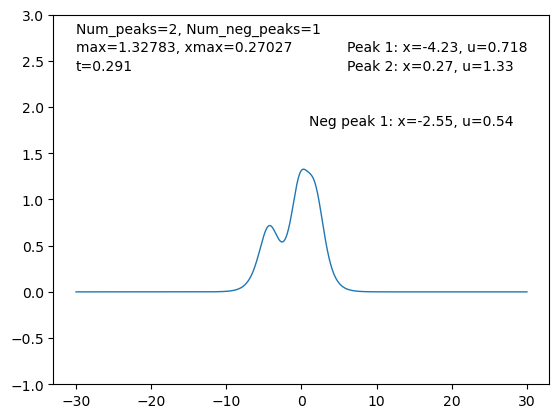

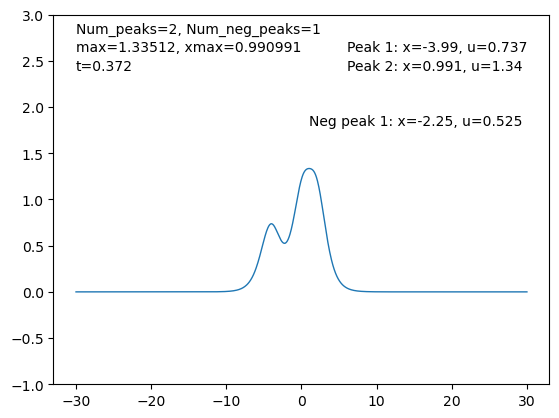

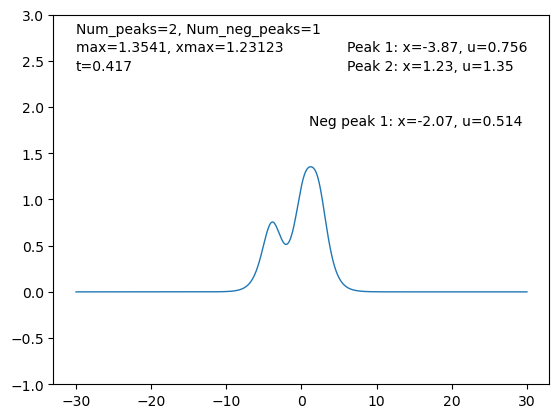

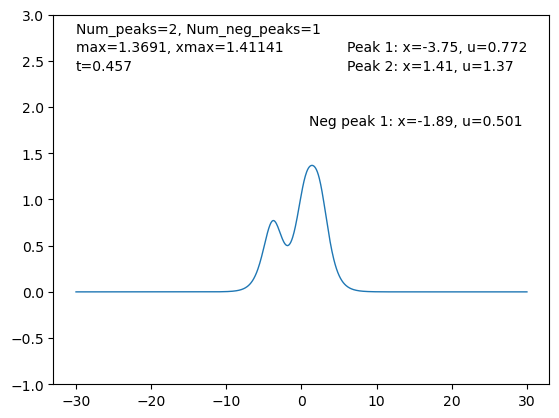

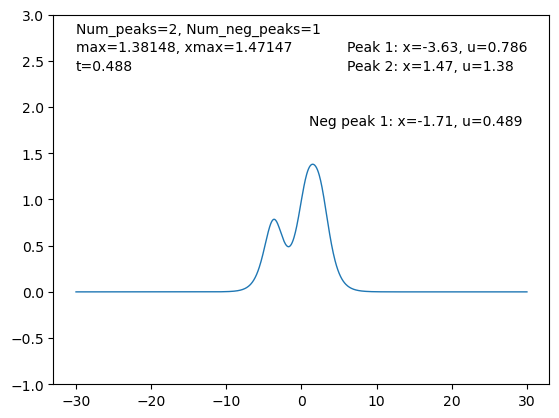

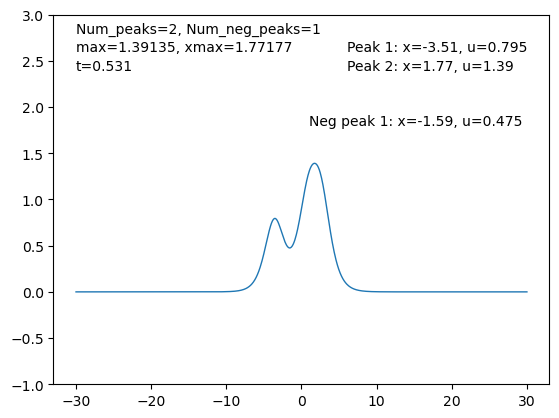

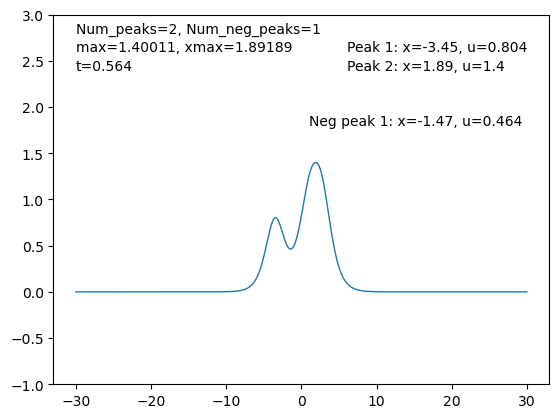

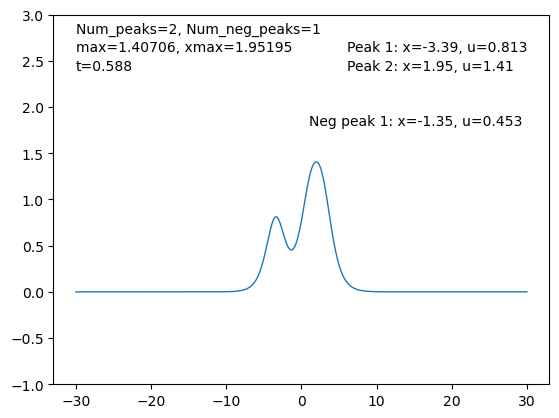

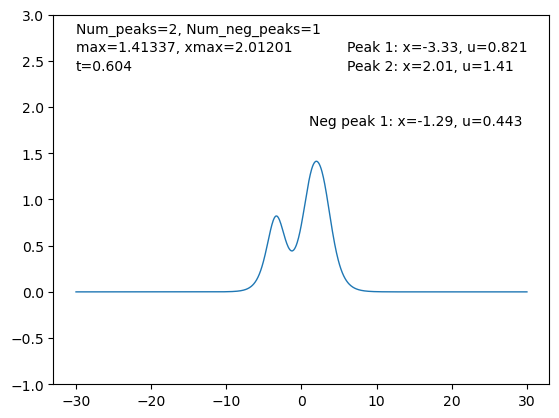

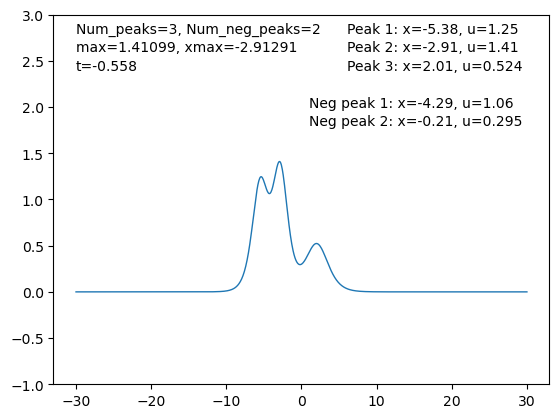

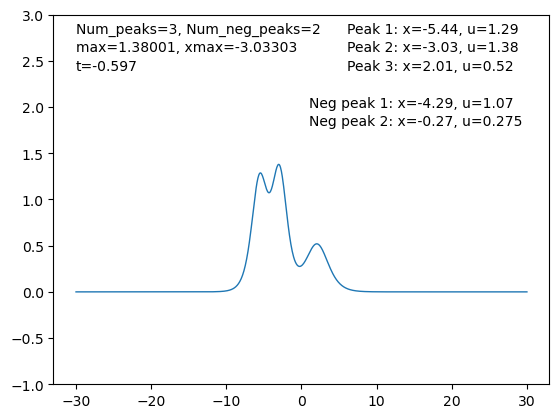

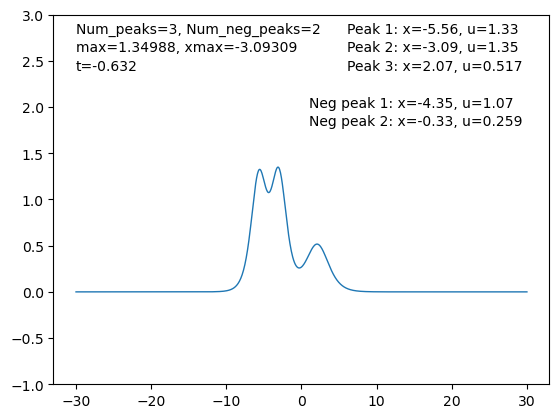

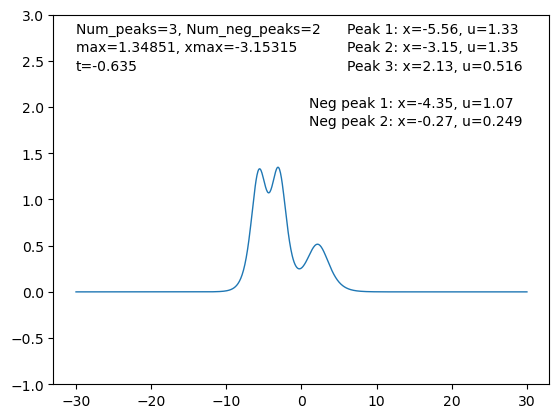

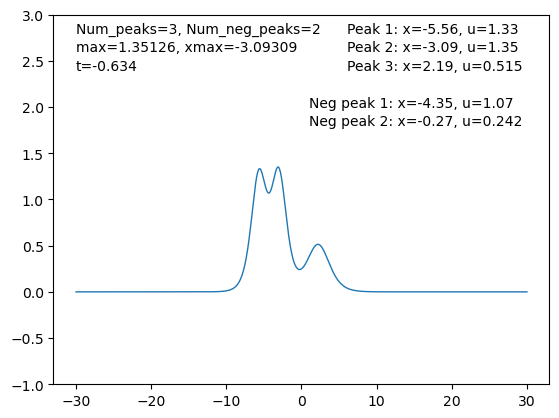

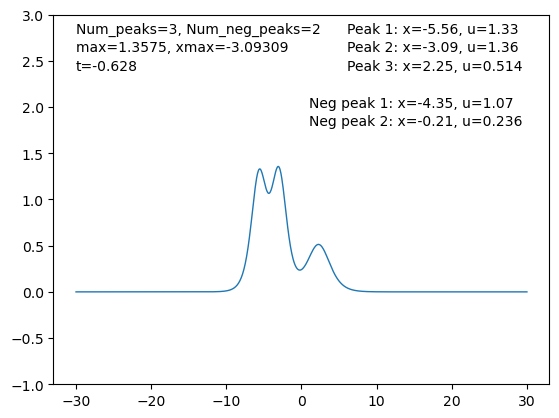

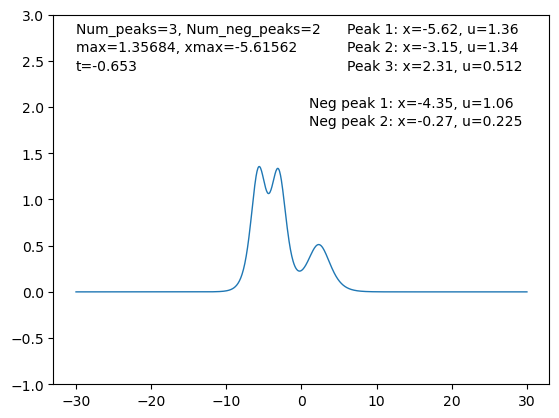

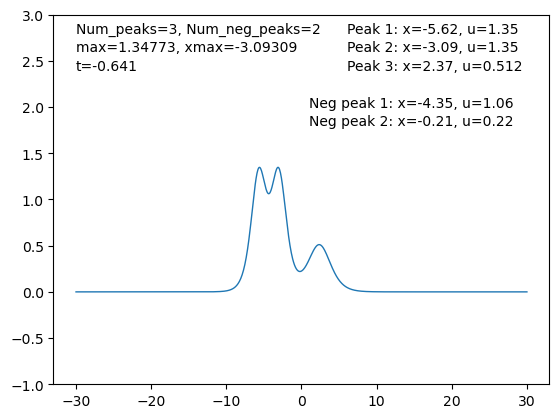

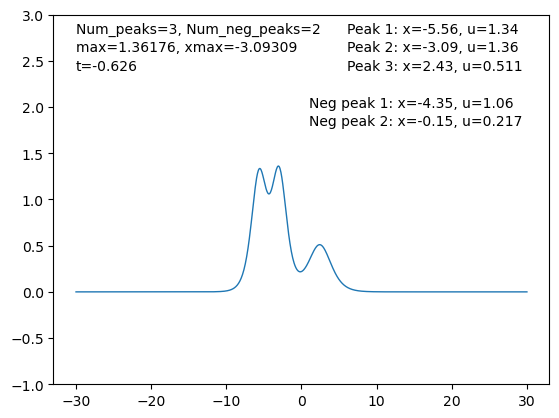

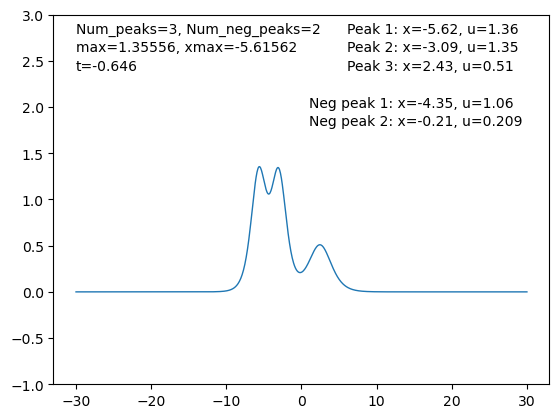

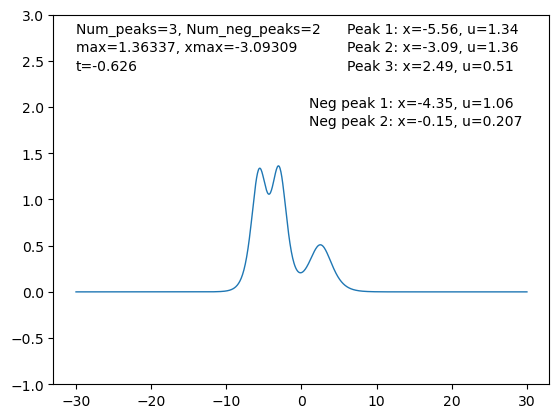

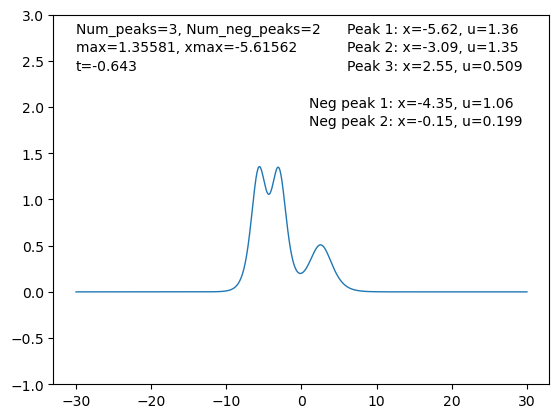

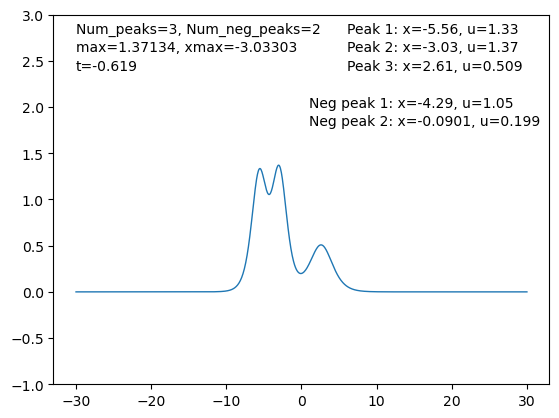

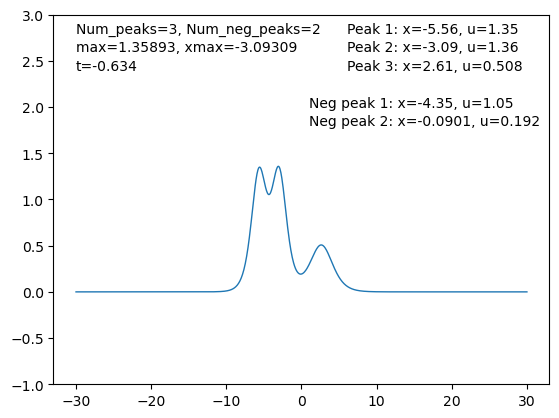

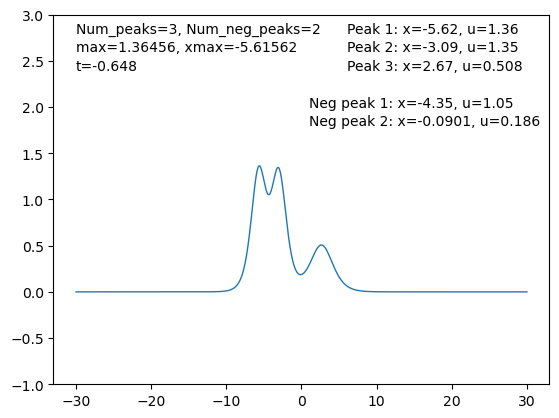

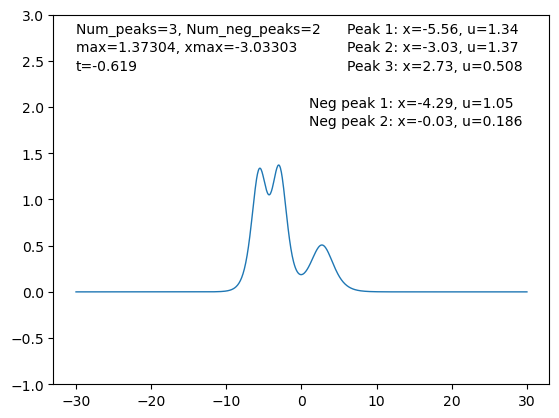

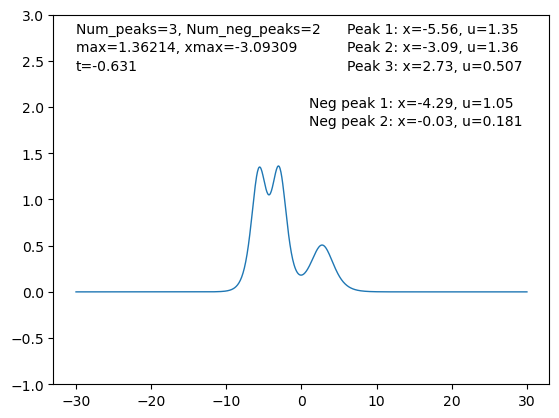

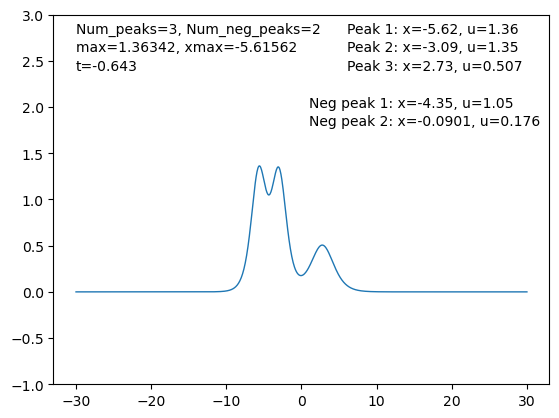

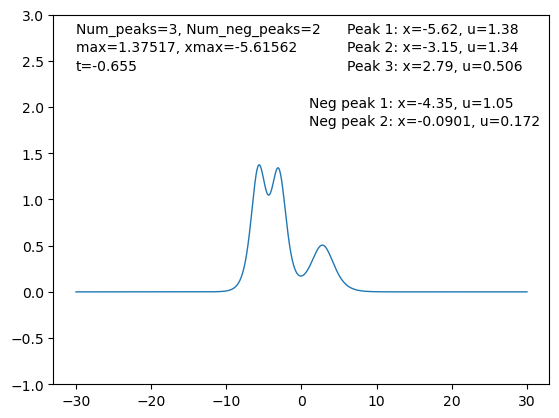

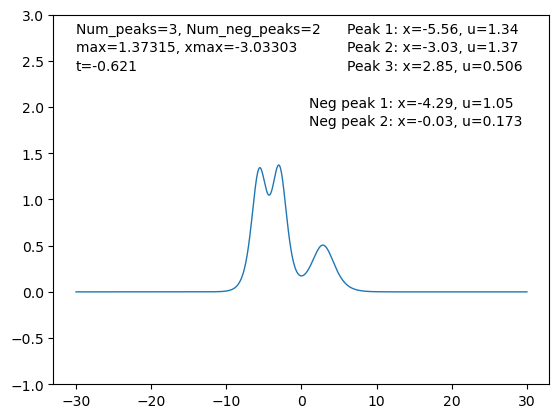

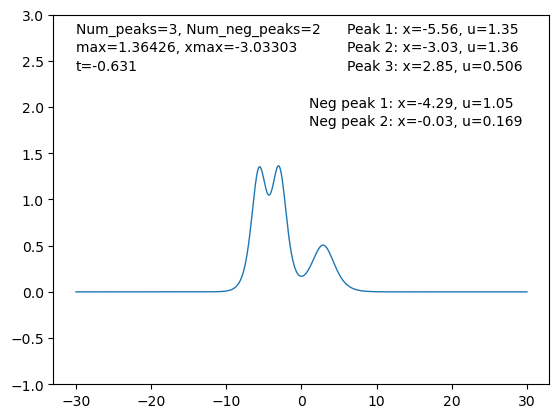

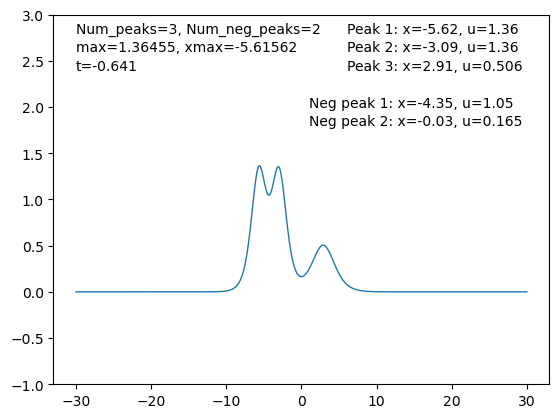

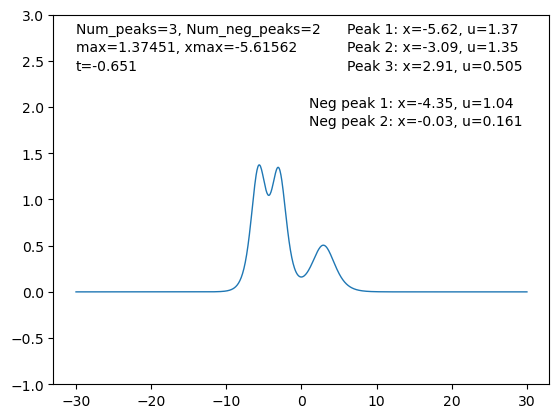

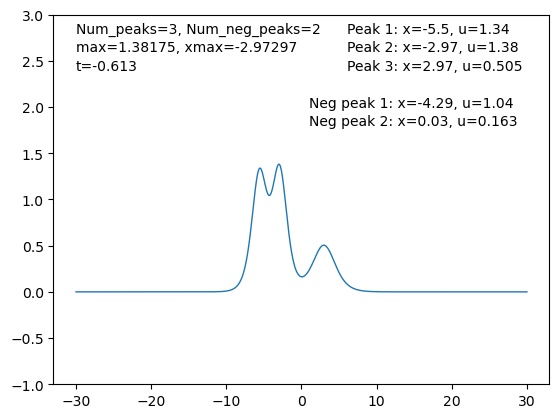

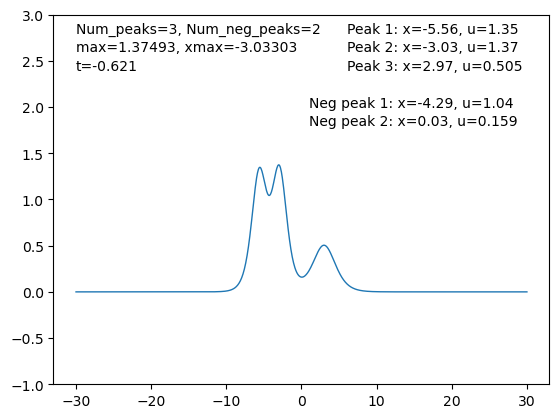

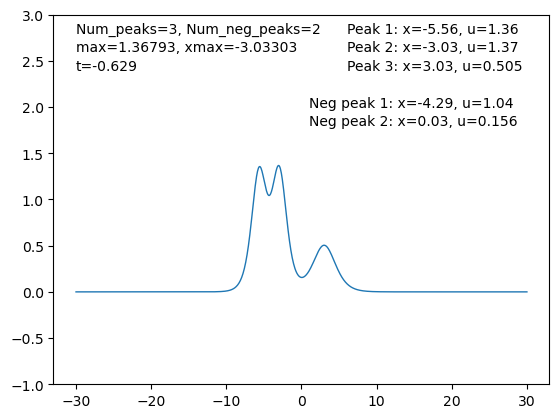

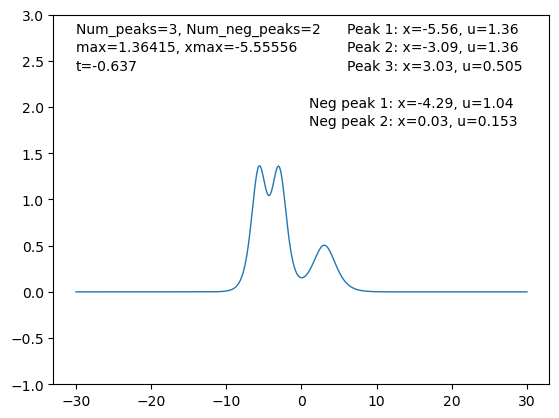

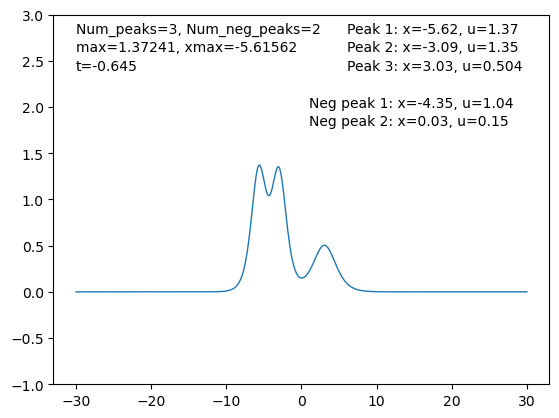

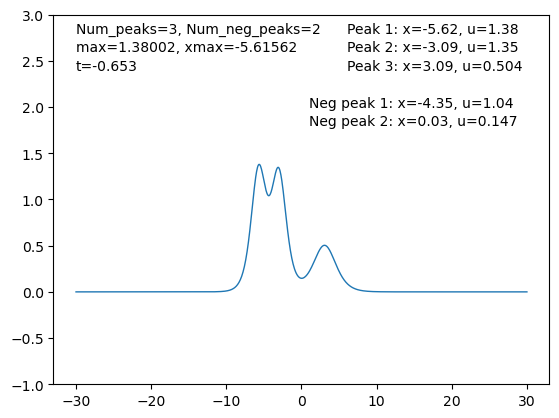

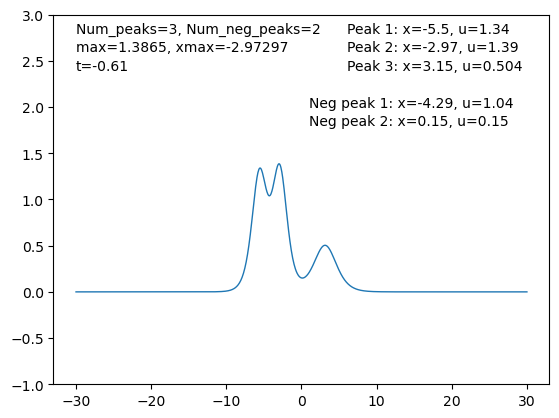

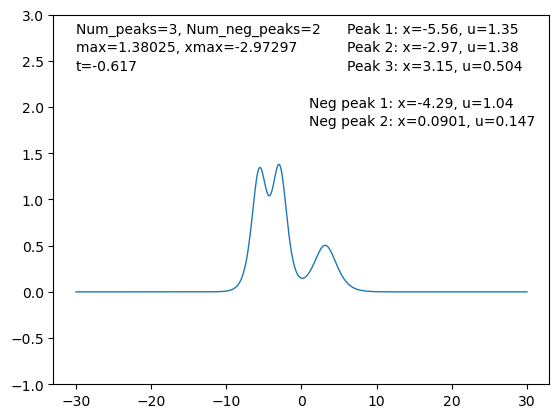

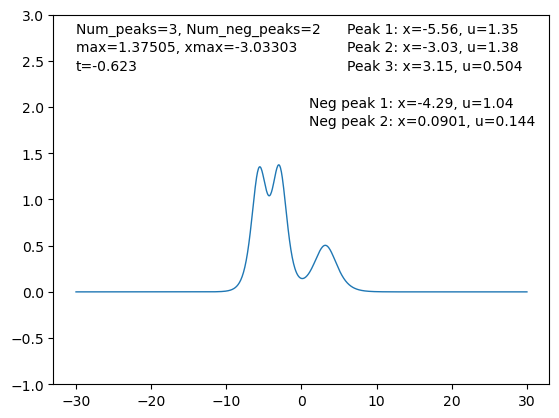

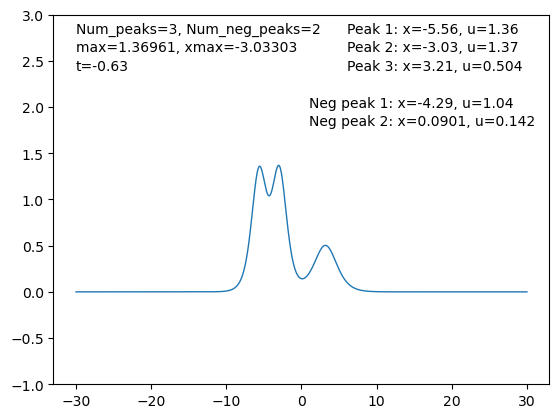

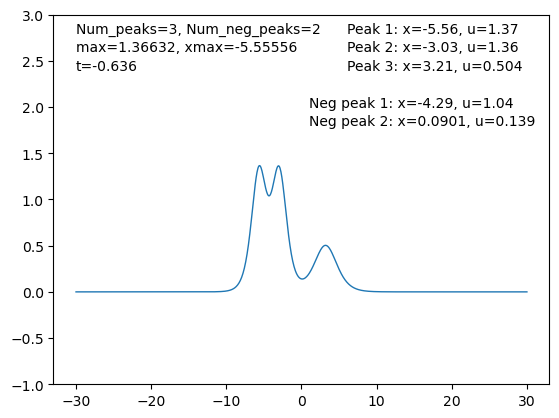

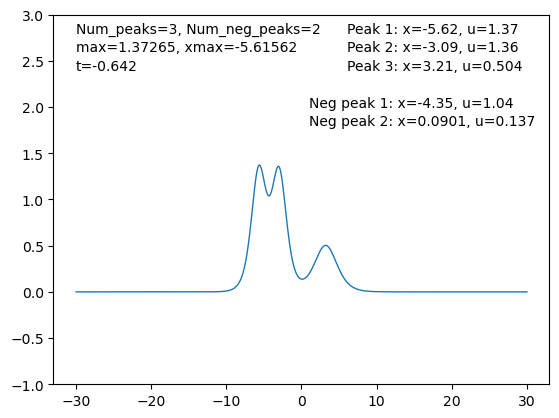

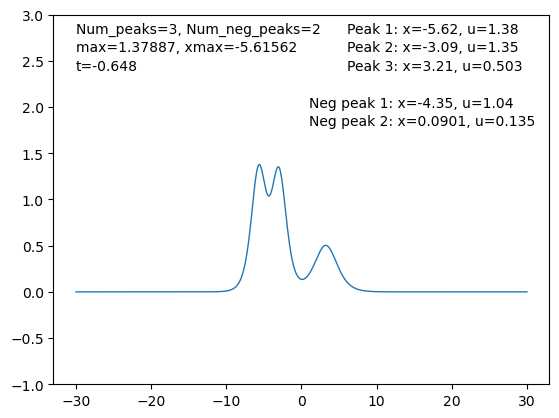

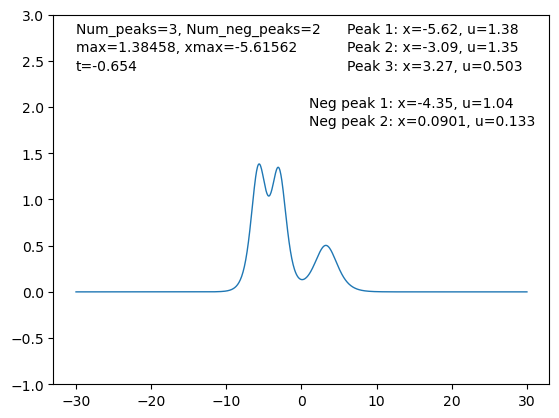

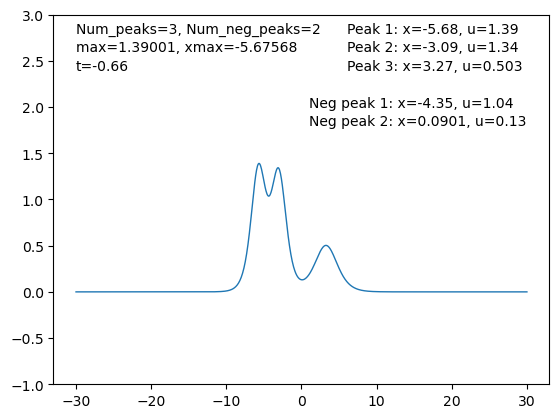

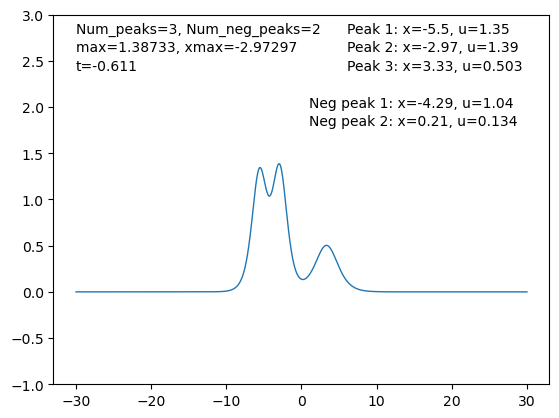

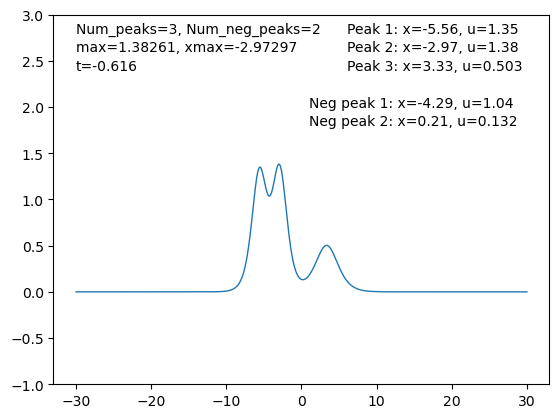

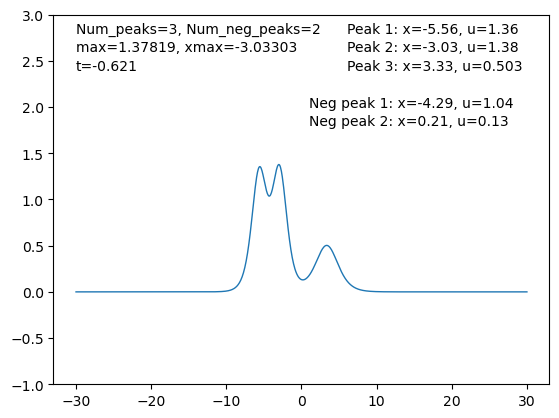

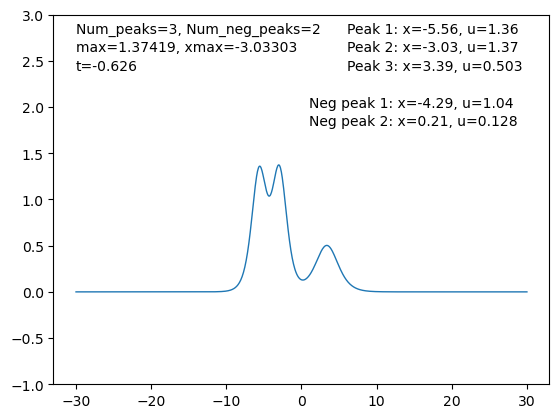

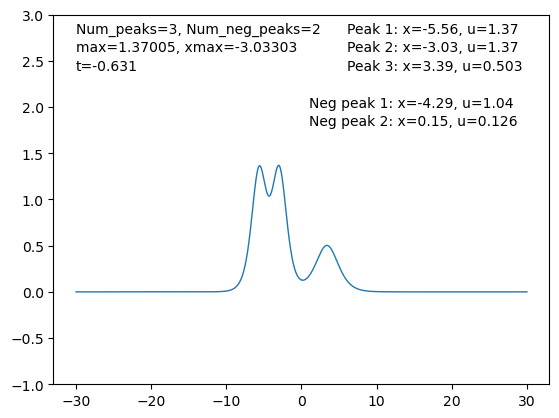

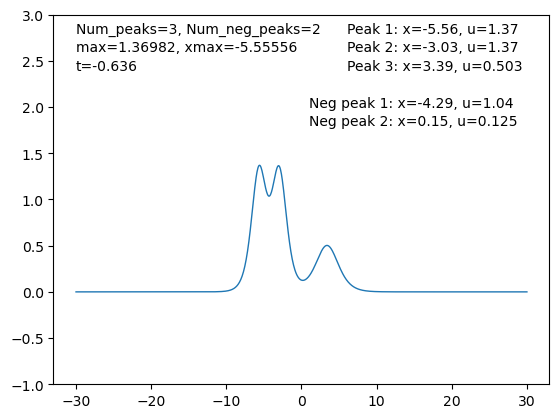

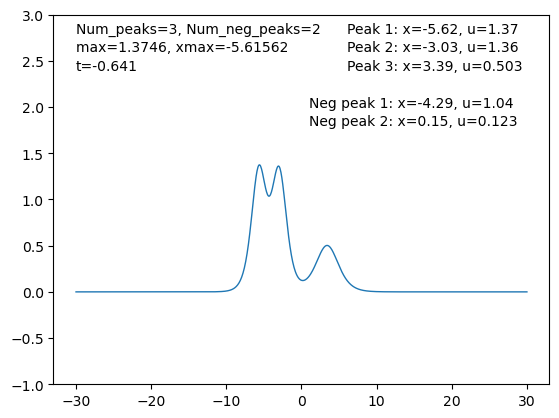

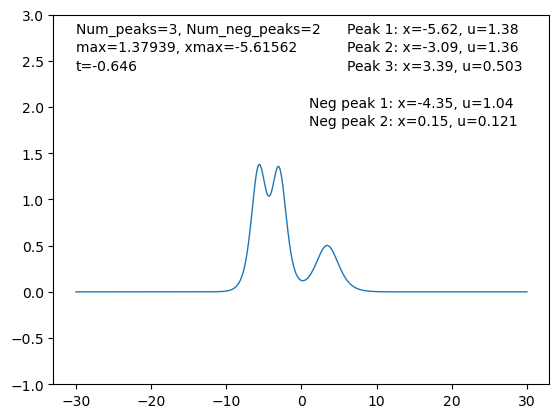

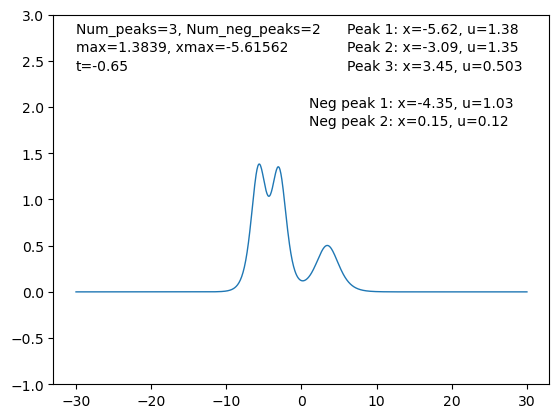

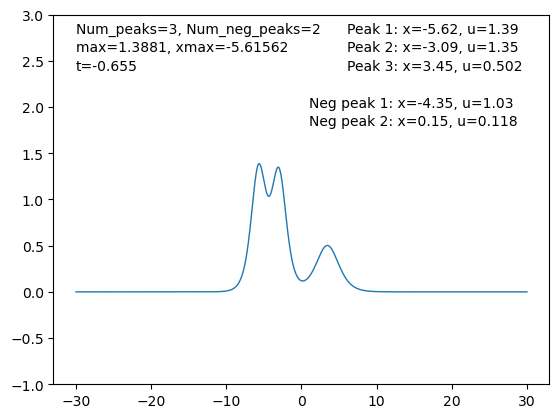

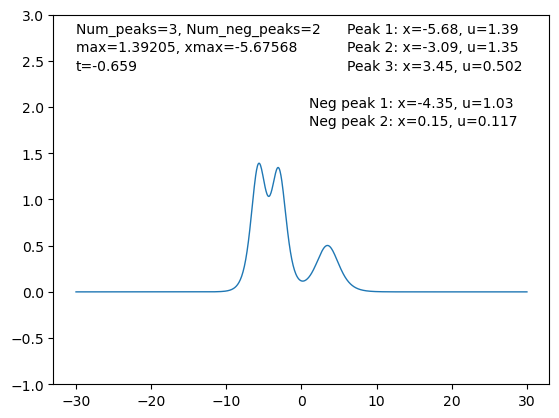

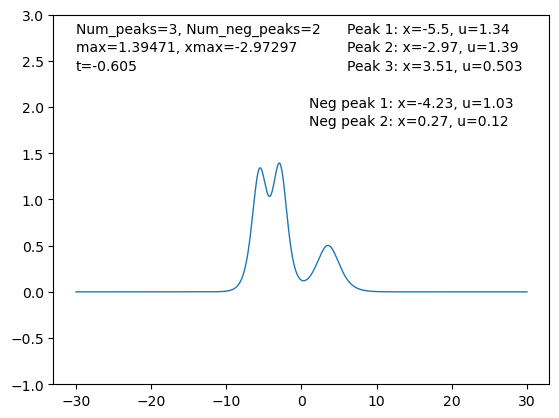

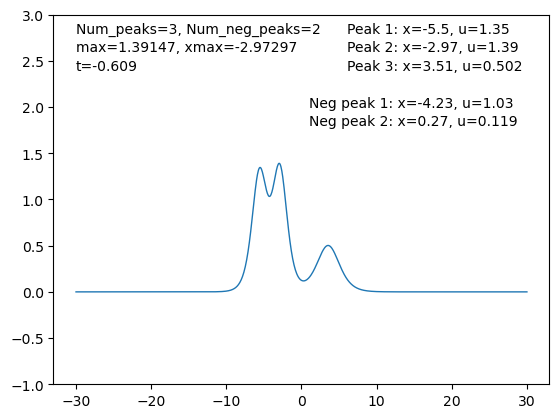

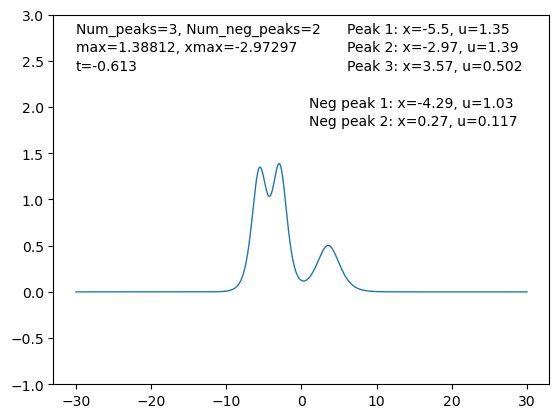

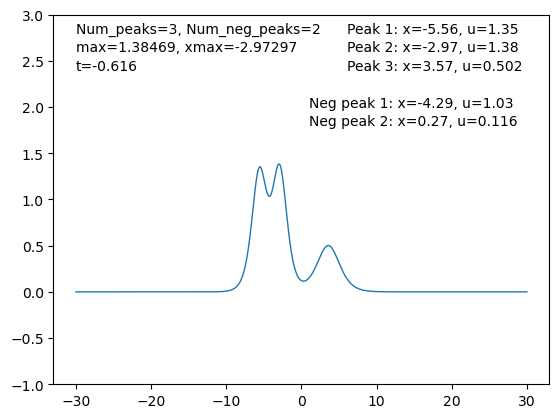

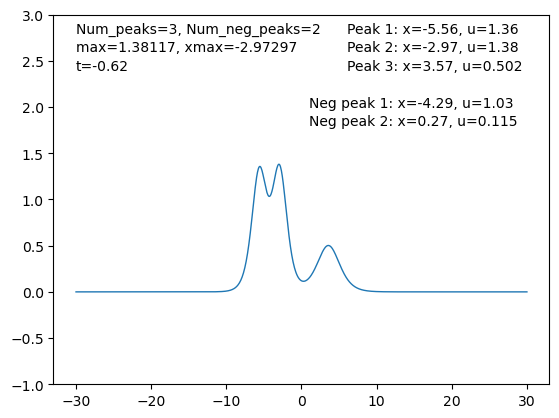

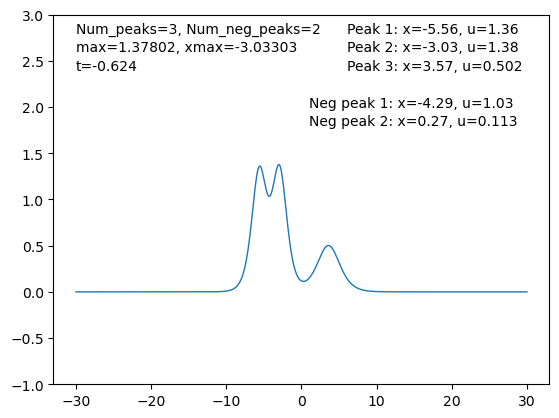

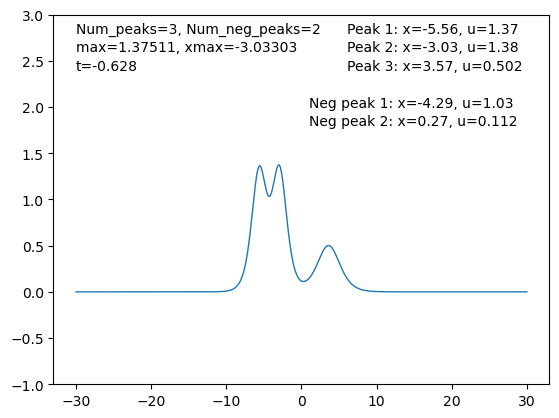

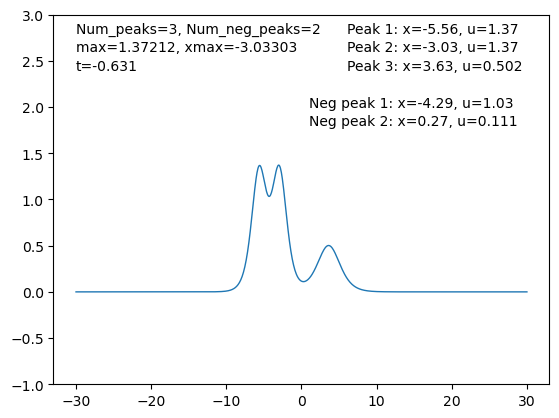

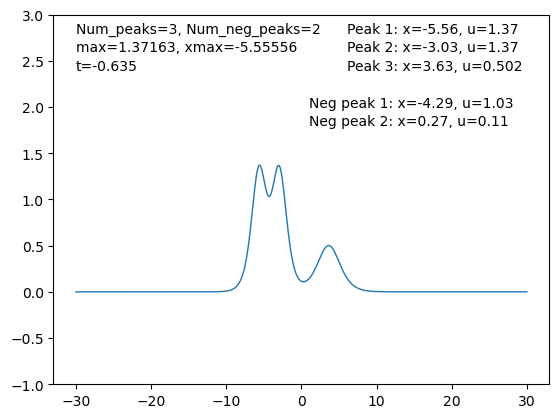

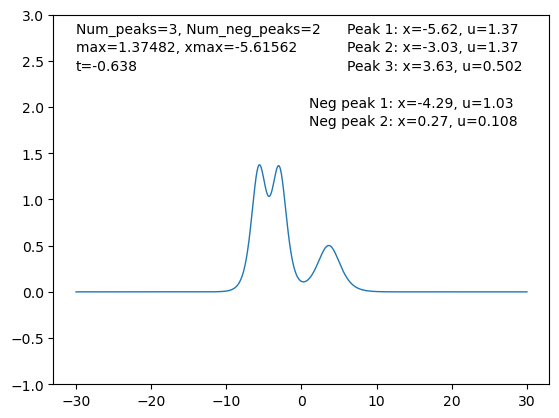

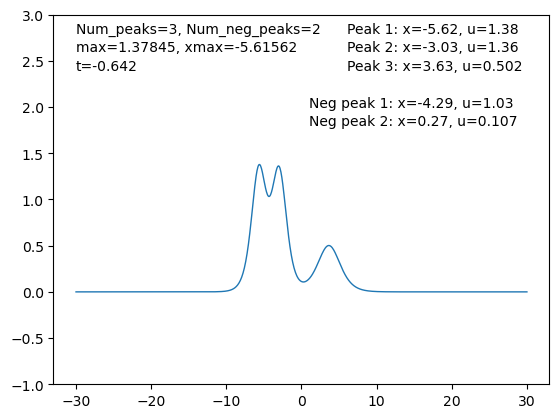

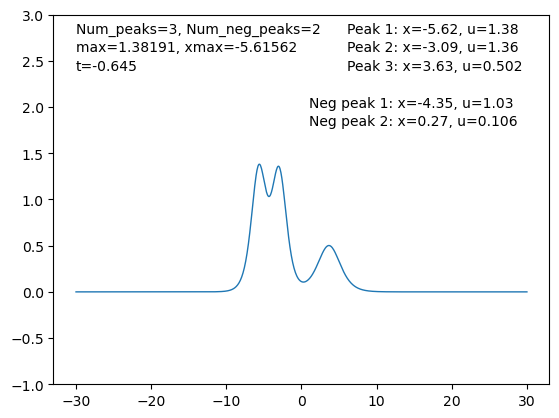

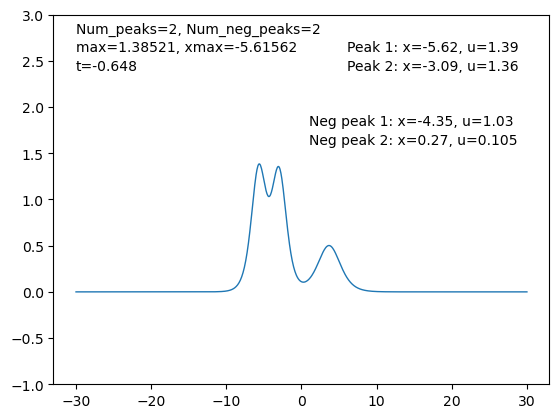

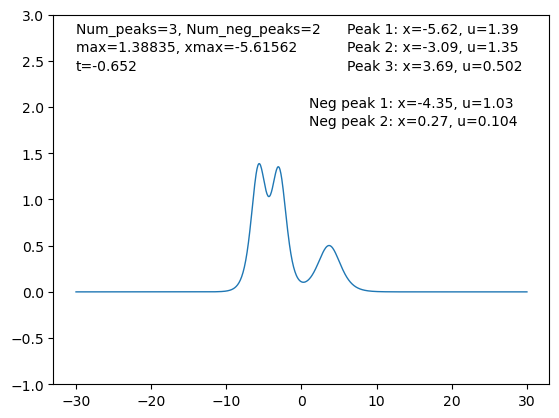

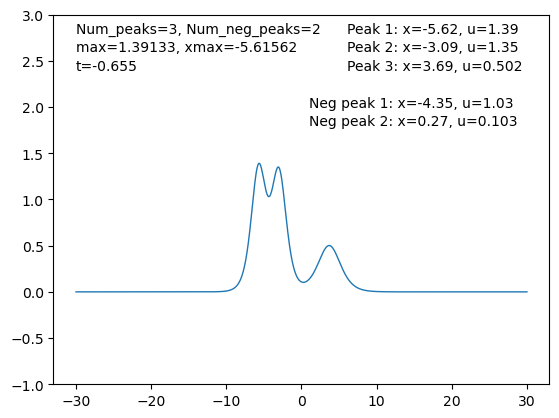

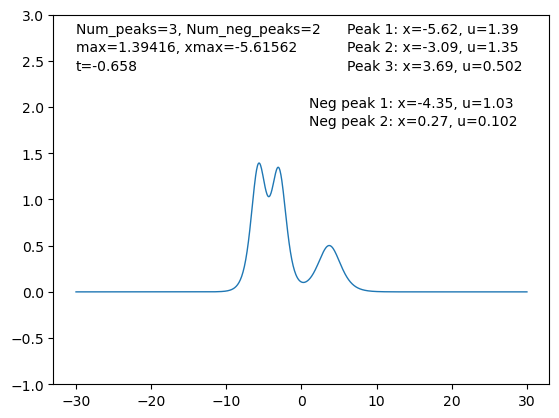

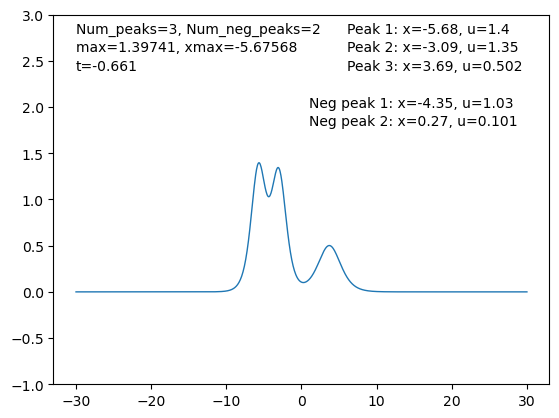

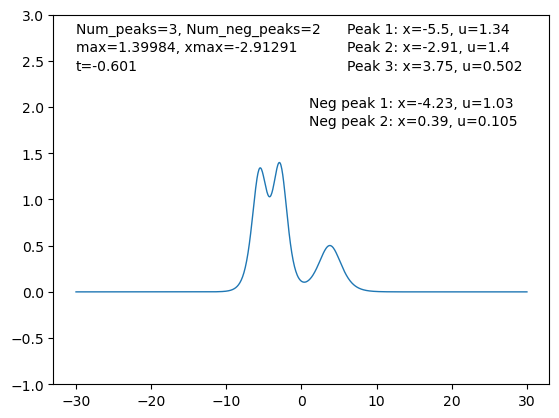

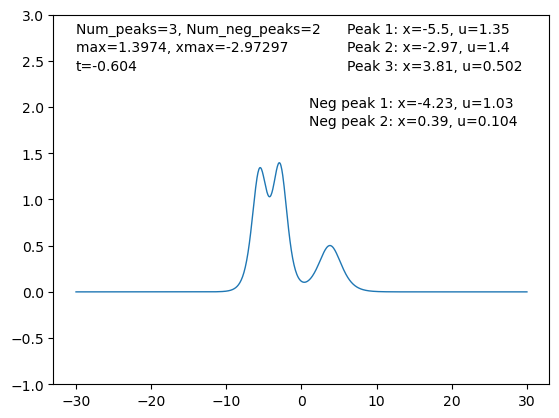

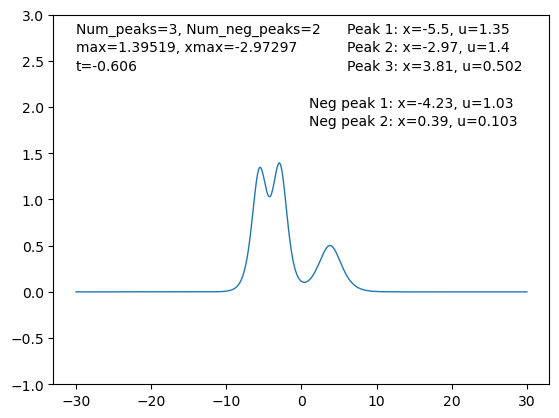

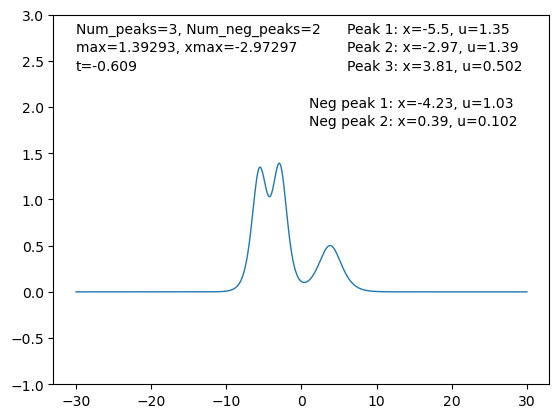

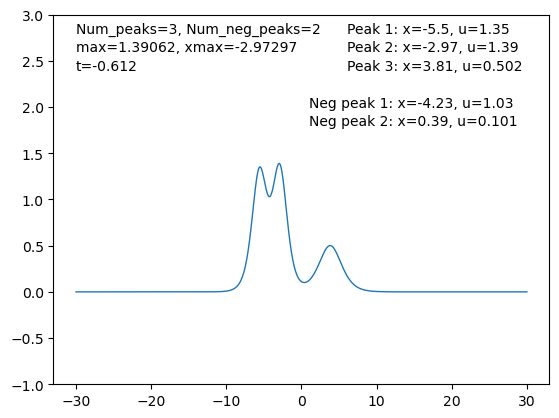

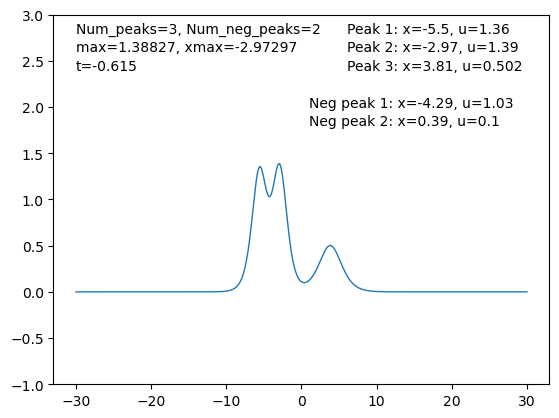

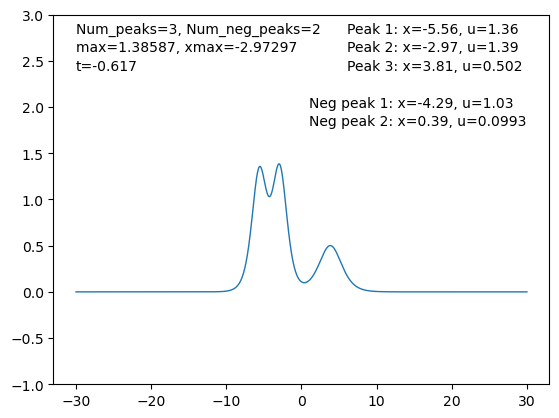

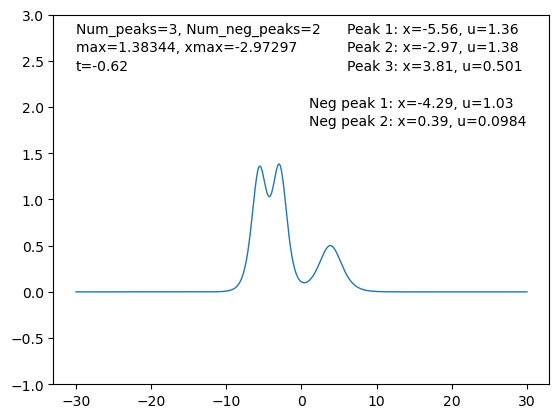

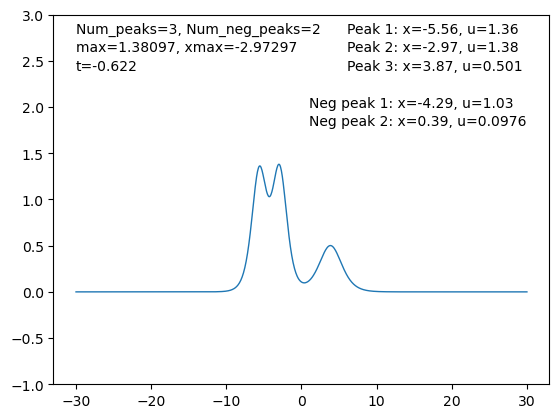

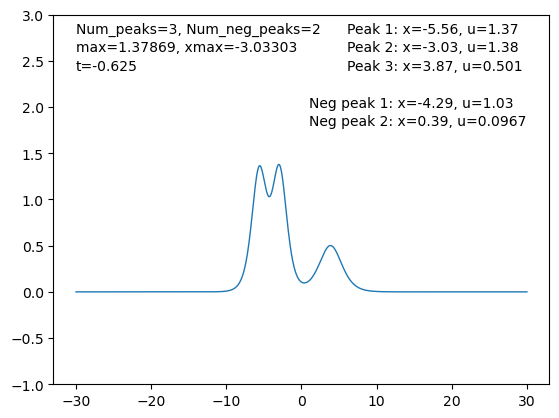

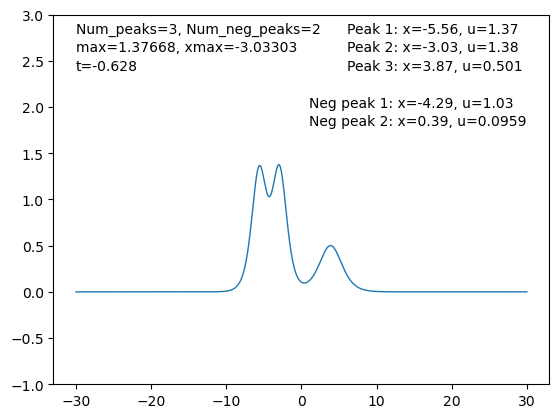

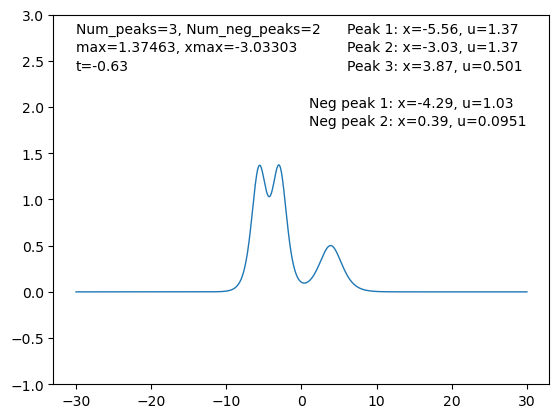

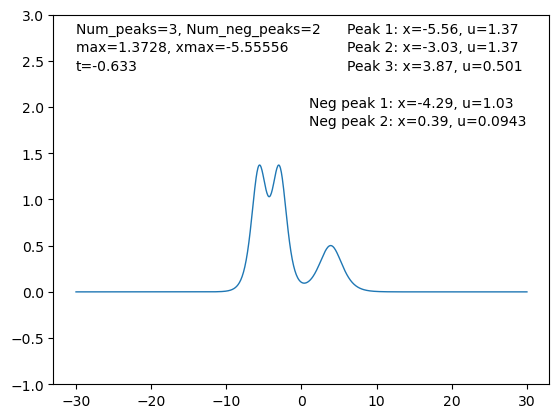

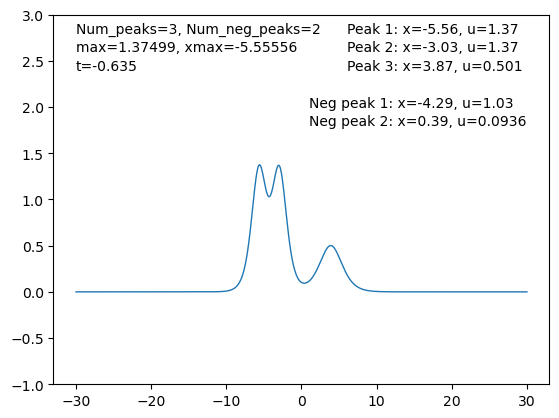

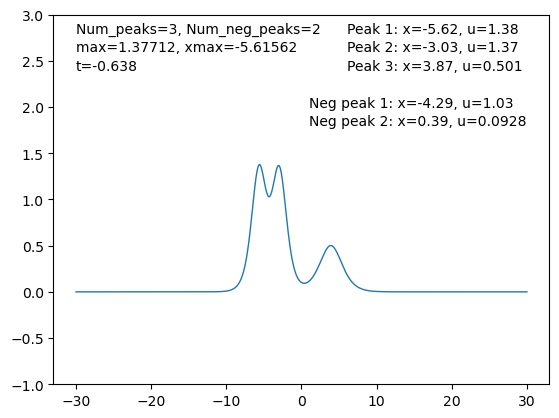

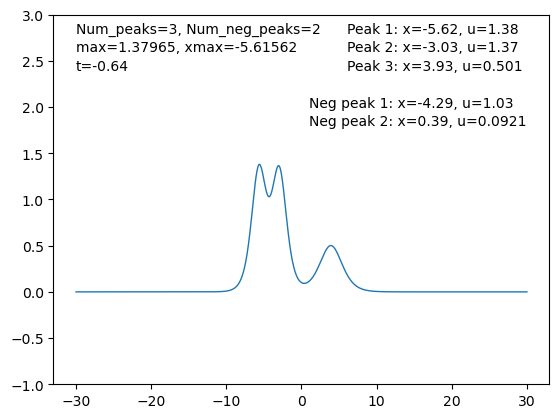

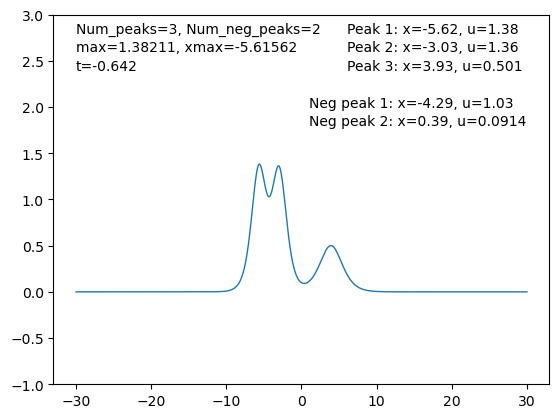

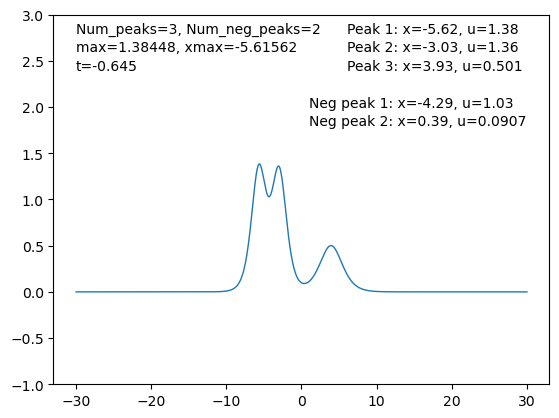

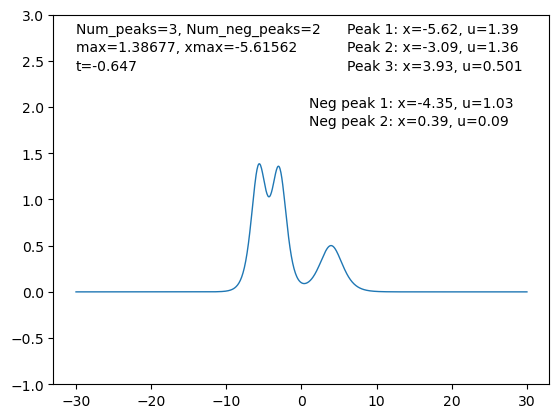

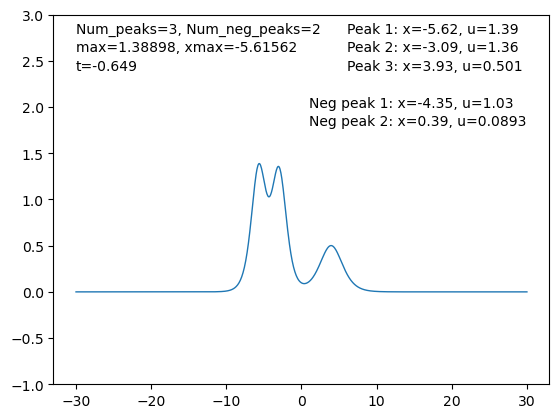

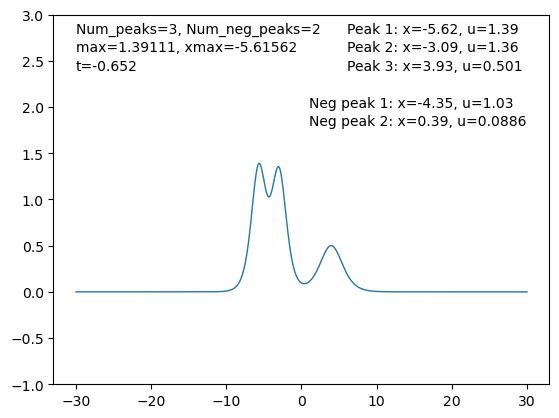

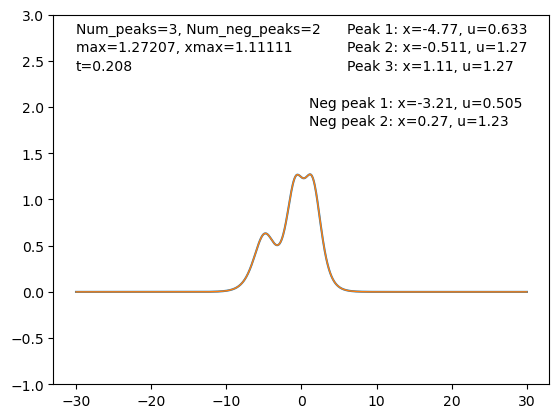

(np.float64(1.2720650427815863), np.float64(2.118181818181818))

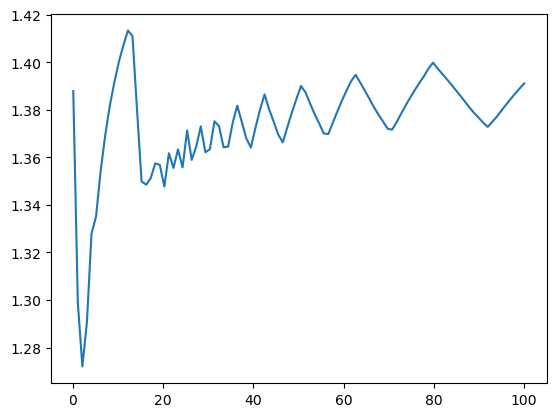

In [7]:
kappa1 = 1; gamma1square = 3;
kappa2 = 0.7; gamma2square = 4;
kappa3 = 0.5;


find_gamma3((kappa1, gamma1square), (kappa2, gamma2square), kappa3)

In [11]:
#def find_kappa3(soliton1, soliton2):
#    kappa1, gamma1 = soliton1
#    kappa2, gamma2 = soliton2

#    x12, t12 = find_x0_t0(sol1, sol2)

#    kappa3squarearr = np.linspace(1, 100, 10000)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]
counter: 0
gamma3square:1.0
counter: 1
gamma3square:2.0
counter: 2
gamma3square:3.0
counter: 3
gamma3square:4.0
counter: 4
gamma3square:5.0
counter: 5
gamma3square:6.0
counter: 6
gamma3square:7.0
counter: 7
gamma3square:8.0
counter: 8
gamma3square:9.0
counter: 9
gamma3square:10.0
counter: 10
gamma3square:11.0
counter: 11
gamma3square:12.0
counter: 12
gamma3square:13.0
counter: 13
gamma3square:14.0
counter: 14
gamma3square:15.0
counter: 15
gamma3square:16.0
counter: 16
gamma3square:17.0


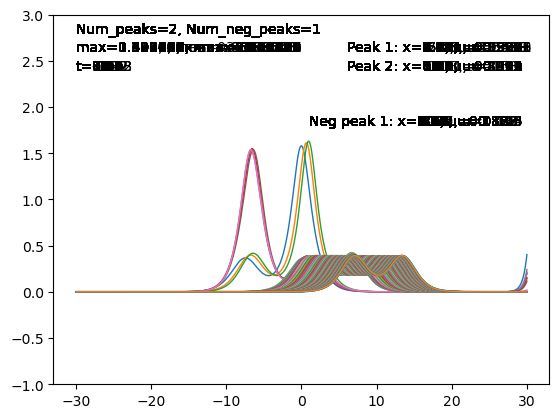

(np.float64(0.39180991892907713), np.float64(97.0))

In [42]:
find_gamma3(sol1, sol2, 0.4)

In [41]:
kappa3

0.9

In [36]:
#def find_kappa3(sol1, sol2, gamma3square_guess=2.6, kappa3_min=0.3, kappa3_max=1.2, num=100):
#def find_kappa3(sol1, sol2, gamma3square_guess=2.6, num=100):

def find_kappa3(sol1, sol2, num=100):
    kappa3_min=0.01
    kappa3_max=sol2[0]-0.01
    
    kappa3_arr = np.linspace(kappa3_min, kappa3_max, num)

    uinfsuparr = []
    time_index_arr = []
    time_arr = []
    wholeu_arr = []


    counter = 0
    for kappa3 in kappa3_arr:
        print("counter: {}\nkappa3:{}".format(counter, kappa3))
        counter += 1

        _, gamma3square = find_gamma3(sol1, sol2, kappa3)

        
        xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, (kappa3, gamma3square), 0)
        
        wholeu_arr.append(u)
        uinfsuparr.append(uinfsup)
        time_index_arr.append(time_index)
        time_arr.append(time)
        
        make_plot(xarr, u[time_index, :], time, show=0)


    index = np.argmin(uinfsuparr)
    kappa3_arr[index]
    
    plt.plot(xarr, wholeu_arr[index][time_index_arr[index], :], )
    make_plot(xarr, wholeu_arr[index][time_index_arr[index], :], time_arr[index])
    
    plt.show()
    return (np.min(np.array(uinfsuparr)), kappa3_arr[index])

counter: 0
kappa3:0.01
counter: 1
kappa3:0.014848484848484849
counter: 2
kappa3:0.0196969696969697
counter: 3
kappa3:0.024545454545454544
counter: 4
kappa3:0.029393939393939396
counter: 5
kappa3:0.03424242424242424
counter: 6
kappa3:0.03909090909090909
counter: 7
kappa3:0.04393939393939394
counter: 8
kappa3:0.04878787878787879


/var/folders/0g/zq5xcmdx6kn3b2080kbrfp7h0000gn/T/ipykernel_91898/2150652963.py:35: RuntimeWarning: overflow encountered in exp
  exp1 = np.where(theta1 <= 0, np.exp(theta1), np.exp(-theta1))


counter: 9
kappa3:0.05363636363636364
counter: 10
kappa3:0.05848484848484849
counter: 11
kappa3:0.06333333333333332
counter: 12
kappa3:0.06818181818181818
counter: 13
kappa3:0.07303030303030303
counter: 14
kappa3:0.07787878787878787
counter: 15
kappa3:0.08272727272727272
counter: 16
kappa3:0.08757575757575757
counter: 17
kappa3:0.09242424242424242
counter: 18
kappa3:0.09727272727272727
counter: 19
kappa3:0.10212121212121211
counter: 20
kappa3:0.10696969696969696
counter: 21
kappa3:0.11181818181818182
counter: 22
kappa3:0.11666666666666665
counter: 23
kappa3:0.1215151515151515
counter: 24
kappa3:0.12636363636363637
counter: 25
kappa3:0.13121212121212122
counter: 26
kappa3:0.13606060606060608
counter: 27
kappa3:0.14090909090909093
counter: 28
kappa3:0.14575757575757575
counter: 29
kappa3:0.1506060606060606
counter: 30
kappa3:0.15545454545454546
counter: 31
kappa3:0.1603030303030303
counter: 32
kappa3:0.16515151515151516
counter: 33
kappa3:0.17
counter: 34
kappa3:0.17484848484848486
count

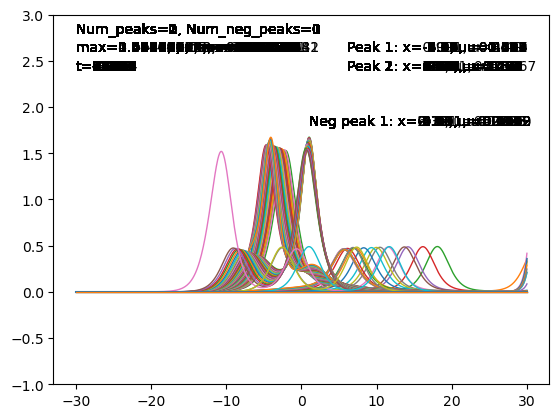

Minimum u_sup: 1.0909229656937917e-05
Optimal kappa3: 0.01


In [37]:
sol1 = (1, 2.0)   # (kappa1, gamma1^2)
sol2 = (0.5, 1.5)

result = find_kappa3(sol1, sol2, gamma3square_guess=2.6, num=100)

print("Minimum u_sup:", result[0])
print("Optimal kappa3:", result[1])

In [ ]:
#for i, kappa3 in enumerate(kappa3_arr):
#        print(f"[{i+1}/{num}] kappa3 = {kappa3:.4f}")
        
#        sol3 = (kappa3, gamma3square_guess)
        
#        try:
#            xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, sol3, plot=0)
#        except Exception as e:
#            print(f"Failed at kappa3 = {kappa3}: {e}")
#            uinfsup = np.inf
#            u = None
        
#        uinfsuparr.append(uinfsup)
#        time_index_arr.append(time_index)
#        time_arr.append(time)
#        full_u_arr.append(u)

In [29]:
num = 100
num
kappa3_min = 0.3
kappa3_min
kappa3_max = 1.2
kappa3_max

1.2

In [31]:

kappa3_arr = np.linspace(0.3, 1.2, 100)
kappa3_arr

array([0.3       , 0.30909091, 0.31818182, 0.32727273, 0.33636364,
       0.34545455, 0.35454545, 0.36363636, 0.37272727, 0.38181818,
       0.39090909, 0.4       , 0.40909091, 0.41818182, 0.42727273,
       0.43636364, 0.44545455, 0.45454545, 0.46363636, 0.47272727,
       0.48181818, 0.49090909, 0.5       , 0.50909091, 0.51818182,
       0.52727273, 0.53636364, 0.54545455, 0.55454545, 0.56363636,
       0.57272727, 0.58181818, 0.59090909, 0.6       , 0.60909091,
       0.61818182, 0.62727273, 0.63636364, 0.64545455, 0.65454545,
       0.66363636, 0.67272727, 0.68181818, 0.69090909, 0.7       ,
       0.70909091, 0.71818182, 0.72727273, 0.73636364, 0.74545455,
       0.75454545, 0.76363636, 0.77272727, 0.78181818, 0.79090909,
       0.8       , 0.80909091, 0.81818182, 0.82727273, 0.83636364,
       0.84545455, 0.85454545, 0.86363636, 0.87272727, 0.88181818,
       0.89090909, 0.9       , 0.90909091, 0.91818182, 0.92727273,
       0.93636364, 0.94545455, 0.95454545, 0.96363636, 0.97272

In [2]:
kappa3_min = 0.3
kappa3_max = 1.2 
num = 100

In [4]:
kappa3_min

0.3

In [5]:
kappa3_max

1.2

In [6]:
num

100

In [13]:
uinfsuparr = []
type(uinfsuparr)

list

In [32]:
enumerate(kappa3_arr)

In [7]:
kappa3_max = 1.2

In [26]:
def find_gamma2(kappa1, gamma1square, kappa2, kappa3=1.0, gamma3square=2.6, gamma2_min=2.0, gamma2_max=3.0, num=100):

    gamma2square_arr = np.linspace(gamma2_min, gamma2_max, num)
    
    sol1 = (kappa1, gamma1square)
    sol3 = (kappa3, gamma3square)

    uinfsuparr = []
    time_index_arr = []
    time_arr = []
    wholeu_arr = []


    counter = 0
    for gamma2 in gamma2square_arr:
        print("counter: {}\nkappa3:{}".format(counter, gamma2))
        counter += 1
        xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, (gamma2, kappa2), sol3, plot=0)
        
        wholeu_arr.append(u)
        uinfsuparr.append(uinfsup)
        time_index_arr.append(time_index)
        time_arr.append(time)
        
        make_plot(xarr, u[time_index, :], time, show=0)


    index = np.argmin(uinfsuparr)
    gamma2squarearr[index]
    
    plt.plot(xarr, wholeu_arr[index][time_index_arr[index], :], )
    make_plot(xarr, wholeu_arr[index][time_index_arr[index], :], time_arr[index])
    
    plt.show()
    return (np.min(np.array(uinfsuparr)), gamma2squarearr[index])

In [27]:
kappa1 = 1.0
gamma1 = 3.0
kappa2 = 0.75

gamma2_opt = find_gamma2(kappa1, gamma1, kappa2, kappa3=1.0, gamma3square=2.6, gamma2_min=2.0, gamma2_max=3.0, num=100)

print("Optimal gamma2:", gamma2_opt)

counter: 0
kappa3:2.0


/var/folders/0g/zq5xcmdx6kn3b2080kbrfp7h0000gn/T/ipykernel_91898/2236754003.py:8: RuntimeWarning: invalid value encountered in log
  Mat[0][2] = 1/(2*kappa1) * np.log(gamma1square / (2*kappa1)) - 1/(2*kappa1)*np.log((kappa1+kappa2)/(kappa1-kappa2))
/var/folders/0g/zq5xcmdx6kn3b2080kbrfp7h0000gn/T/ipykernel_91898/2236754003.py:12: RuntimeWarning: invalid value encountered in log
  Mat[1][2] = 1/(2*kappa2) * np.log(gamma2square / (2*kappa2)) - 1/(2*kappa2)*np.log((kappa1+kappa2)/(kappa1-kappa2))


ZeroDivisionError: float division by zero

In [ ]:
gamma2square = 2.5
kappa2 = 0.95
sol2 = (kappa2, gamma2square)


In [ ]:
#try:
#    xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, sol3, plot=0)
#except Exception as e:
#    print(f"Error at gamma2² = {gamma2square:.4f}: {e}")
#    uinfsup = np.inf
#    u = None

In [ ]:
#for i, gamma2square in enumerate(gamma2square_arr):
#        print(f"[{i+1}/{num}] gamma2² = {gamma2square:.5f}")

#        sol2 = (kappa2, gamma2square)

#        try:
#            xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, sol3, plot=0)
#        except Exception as e:
#            print(f"Error at gamma2² = {gamma2square:.4f}: {e}")
#            uinfsup = np.inf
#            u = None

#        uinfsuparr.append(uinfsup)
#        time_index_arr.append(time_index)
#        time_arr.append(time)
#        full_u_arr.append(u)
